In [121]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [122]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('noisy_labels.csv', delimiter=',', dtype="int8")

In [123]:
noisy_labels

array([3, 5, 9, ..., 9, 1, 1], dtype=int8)

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

In [124]:
len(noisy_labels)

50000

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


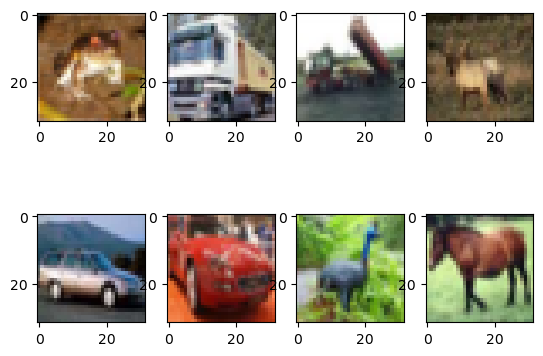

In [125]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [84]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [85]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [86]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping 

import time


start_time = time.time()

def build_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    # initialize the model as a sequential model
    model = models.Sequential([ 
        # add a convolutional layer with 64 filters, a 3x3 kernel, using 'same' padding, and ReLU activation. It's the first layer
        layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        # add batch normalization to normalize the activations of the previous layer
        layers.BatchNormalization(),
        # another convolutional layer with 64 filters and ReLU activation without padding specification, which defaults to 'valid'
        layers.Conv2D(64, (3, 3), activation='relu'),
        # add max pooling to reduce spatial dimensions by taking the maximum value over a 2x2 pooling window
        layers.MaxPooling2D(pool_size=(2, 2)),
        # add dropout to prevent overfitting by randomly setting a fraction of inputs to 0 during training
        layers.Dropout(0.25),

        # add another set of convolutional layers and batch normalization, similar to above but with 128 filters
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # flatten the output of the previous layer to a 1D array to be used as input for the dense layers
        layers.Flatten(),
        # add a densely connected layer with 1024 neurons and ReLU activation
        layers.Dense(1024, activation='relu'),
        # add another batch normalization step
        layers.BatchNormalization(),
        # add dropout to further prevent overfitting
        layers.Dropout(0.5),
        # add a final densely connected layer with a number of neurons equal to the number of classes, using softmax activation for multi-class classification
        layers.Dense(num_classes, activation='softmax'),
    ])

    # compile the model with Adam optimizer, sparse categorical crossentropy as the loss function, and track accuracy as a metric
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

x_train = imgs[10000:] / 255 
x_test = imgs[:10000] / 255 
y_train = noisy_labels[10000:]  
y_test = clean_labels

model = build_cnn_model() 

# early stopping to halt training 
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# train the model
history = model.fit(x_train, y_train, batch_size=32,
                    epochs=10, 
                    validation_data=(x_test, y_test), 
                    callbacks=[early_stopping])  

# extract training and validation accuracy from the training 
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print("Training accuracy: ", train_acc[-1])  # print the last training accuracy
print("Validation accuracy: ", val_acc[-1])  # print the last validation accuracy

# evaluate the model on the test dataset to get the loss value & metrics values
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)  # print the test accuracy
end_time = time.time()

print(f"Runtime of the first part: {end_time - start_time} seconds")

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 65ms/step - accuracy: 0.1206 - loss: 2.7503 - val_accuracy: 0.1388 - val_loss: 3.0546
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 65ms/step - accuracy: 0.1519 - loss: 2.4058 - val_accuracy: 0.2125 - val_loss: 2.2662
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 65ms/step - accuracy: 0.1647 - loss: 2.3489 - val_accuracy: 0.3250 - val_loss: 1.9991
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 65ms/step - accuracy: 0.1652 - loss: 2.3106 - val_accuracy: 0.2945 - val_loss: 2.0657
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.1689 - loss: 2.2906 - val_accuracy: 0.3878 - val_loss: 1.9370
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.1807 - loss: 2.2679 - val_accuracy: 0.3882 - val_loss: 1.9419
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.2014 - loss: 2.2463 - val_accuracy: 0.4310 - val_loss: 1.8101
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.2038 -

In [79]:
from keras.models import load_model

model.save("model1.hdf5")

### 2.3. Model II

In [9]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

In [11]:
pip install h5py==3.7.0

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.6 MB 1.3 MB/s eta 0:00:02
   --- ------------------------------------ 0.2/2.6 MB 2.5 MB/s eta 0:00:01
   ------ --------------------------------- 0.5/2.6 MB 2.9 MB/s eta 0:00:01
   -------------- ------------------------- 1.0/2.6 MB 4.8 MB/s eta 0:00:01
   ---------------- ----------------------- 1.1/2.6 MB 4.5 MB/s eta 0:00:01
   ------------------ --------------------- 1.2/2.6 MB 4.1 MB/s eta 0:00:01
   ------------------------ --------------- 1.6/2.6 MB 5.0 MB/s eta 0:00:01
   ----------------------------- ---------- 1.9/2.6 MB 4.9 MB/s eta 0:00:01
   ------------------------------------- -- 2.4/2.6 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 5.6 MB/s eta 0:00:00
  Attempting uninstall: h5py
    Found existing installation: h5py 3.10.0
    Uninstalling h5py-3.10.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.16.1 requires h5py>=3.10.0, but you have h5py 3.7.0 which is incompatible.


without kfolds

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
imgs_normalized = imgs / 255.0
clean_imgs_train = imgs_normalized[:10000]  
clean_labels_train = clean_labels
noisy_imgs_train = imgs_normalized[10000:]
noisy_labels_train = noisy_labels[10000:] 
augmenter = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # validation loss
    factor=0.5,  # factor by which the learning rate will be reduced
    patience=3,  # number of epochs with no improvement after which learning rate will be reduced
)


from tensorflow.keras.callbacks import ModelCheckpoint


model_checkpoint = ModelCheckpoint(
    'best_model.keras',  
    monitor='val_accuracy',  # validation accuracy
    save_best_only=True, 
    mode='max'  # decision mode 
)


import time


start_time = time.time()


def feature_extractor(input_shape=(32, 32, 3)):

    model = models.Sequential([
        # add a 2D convolutional layer with 32 filters, a 3x3 kernel size, ReLU activation, input shape specified, and 'same' padding
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        # add batch normalization to normalize the activations of the previous layer
        layers.BatchNormalization(),
        # add a max pooling layer with a 2x2 pool size to reduce spatial dimensions
        layers.MaxPooling2D((2, 2)),
        
        # another convolutional layer, now with 64 filters
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        # batch normalization layer after the convolution
        layers.BatchNormalization(),
        # another max pooling layer to further reduce dimensions
        layers.MaxPooling2D((2, 2)),

        # third convolutional layer with 128 filters
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        # followed by batch normalization
        layers.BatchNormalization(),
        # global max pooling to reduce the entire feature map to a single maximum value per feature map 
        layers.GlobalMaxPooling2D(),
    ])
   
    return model



def label_correction_model():
    # input layer for the images
    image_input = Input(shape=(32, 32, 3))
    # input layer for the noisy labels
    noisy_label_input = Input(shape=(10,))
    
    # feature extractor model 
    feature_model = feature_extractor()

    image_features = feature_model(image_input)
    
    # combine the image features and noisy label input
    combined_input = layers.concatenate([image_features, noisy_label_input])
    # add a dense layer with ReLU activation on top of the combined input
    combined_input = layers.Dense(128, activation='relu')(combined_input)
    
    # add a final dense layer with softmax activation to predict the corrected labels
    corrected_labels = layers.Dense(10, activation='softmax')(combined_input)
    
    # create the Model object
    model = Model(inputs=[image_input, noisy_label_input], outputs=corrected_labels)
    # compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model



model2 = label_correction_model()
clean_labels_train_cat = tf.keras.utils.to_categorical(clean_labels_train)
noisy_labels_train_cat = tf.keras.utils.to_categorical(noisy_labels_train)


model2.fit(
    [clean_imgs_train, noisy_labels_train_cat], 
    clean_labels_train_cat, 
    epochs=10,  batch_size=32,
    validation_split=0.2,
    callbacks=[lr_scheduler, model_checkpoint]
)



Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.2916 - loss: 2.2072 - val_accuracy: 0.1625 - val_loss: 2.3881 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4812 - loss: 1.4349 - val_accuracy: 0.3760 - val_loss: 1.6921 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5634 - loss: 1.2450 - val_accuracy: 0.3970 - val_loss: 1.6805 - learning_rate: 0.0010
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6182 - loss: 1.0758 - val_accuracy: 0.4435 - val_loss: 1.5848 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6723 - loss: 0.9284 - val_accuracy: 0.5190 - val_loss: 1.4056 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6977 - loss: 0.8506 - val_accuracy: 0.4955 - val_loss: 1.4654 - learning_rate: 0.0010
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7450 - loss: 0.7163 

with kfolds(run this)

In [11]:
import time


start_time = time.time()
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
imgs_normalized = imgs / 255.0
clean_imgs_train = imgs_normalized[:10000]  
clean_labels_train = clean_labels
noisy_imgs_train = imgs_normalized[10000:]
noisy_labels_train = noisy_labels[10000:] 
augmenter = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # validation loss
    factor=0.5,  # factor by which the learning rate will be reduced
    patience=3,  # number of epochs with no improvement after which learning rate will be reduced
)


from tensorflow.keras.callbacks import ModelCheckpoint


model_checkpoint = ModelCheckpoint(
    'best_model.keras',  
    monitor='val_accuracy',  # validation accuracy
    save_best_only=True, 
    mode='max'  # decision mode 
)





def feature_extractor(input_shape=(32, 32, 3)):

    model = models.Sequential([
        # add a 2D convolutional layer with 32 filters, a 3x3 kernel size, ReLU activation, input shape specified, and 'same' padding
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        # add batch normalization to normalize the activations of the previous layer
        layers.BatchNormalization(),
        # add a max pooling layer with a 2x2 pool size to reduce spatial dimensions
        layers.MaxPooling2D((2, 2)),
        
        # another convolutional layer, now with 64 filters
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        # batch normalization layer after the convolution
        layers.BatchNormalization(),
        # another max pooling layer to further reduce dimensions
        layers.MaxPooling2D((2, 2)),

        # third convolutional layer with 128 filters
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        # followed by batch normalization
        layers.BatchNormalization(),
        # global max pooling to reduce the entire feature map to a single maximum value per feature map 
        layers.GlobalMaxPooling2D(),
    ])
   
    return model



def label_correction_model():
    # input layer for the images
    image_input = Input(shape=(32, 32, 3))
    # input layer for the noisy labels
    noisy_label_input = Input(shape=(10,))
    
    # feature extractor model 
    feature_model = feature_extractor()

    image_features = feature_model(image_input)
    
    # combine the image features and noisy label input
    combined_input = layers.concatenate([image_features, noisy_label_input])
    # add a dense layer with ReLU activation on top of the combined input
    combined_input = layers.Dense(128, activation='relu')(combined_input)
    
    # add a final dense layer with softmax activation to predict the corrected labels
    corrected_labels = layers.Dense(10, activation='softmax')(combined_input)
    
    # create the Model object
    model = Model(inputs=[image_input, noisy_label_input], outputs=corrected_labels)
    # compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


model2 = label_correction_model()
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=5243)
clean_labels_train_cat = tf.keras.utils.to_categorical(clean_labels_train)
noisy_labels_train_cat = tf.keras.utils.to_categorical(noisy_labels_train)

for train_index, val_index in kf.split(clean_imgs_train):
    x_train, x_val = clean_imgs_train[train_index], clean_imgs_train[val_index]
    y_train, y_val = clean_labels_train_cat[train_index], clean_labels_train_cat[val_index]
    noisy_y_train, noisy_y_val = noisy_labels_train_cat[train_index], noisy_labels_train_cat[val_index]

    model2 = label_correction_model()
    model2.fit(
        [x_train, noisy_y_train], y_train,
        validation_data=([x_val, noisy_y_val], y_val),
        epochs=10, batch_size=32,
        callbacks=[lr_scheduler, model_checkpoint]
    )


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3037 - loss: 2.1779 - val_accuracy: 0.1415 - val_loss: 2.5312 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4660 - loss: 1.4585 - val_accuracy: 0.4205 - val_loss: 1.6501 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5497 - loss: 1.2373 - val_accuracy: 0.4765 - val_loss: 1.4875 - learning_rate: 0.0010
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6162 - loss: 1.0794 - val_accuracy: 0.4550 - val_loss: 1.6610 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6596 - loss: 0.9532 - val_accuracy: 0.5030 - val_loss: 1.4213 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7123 - loss: 0.8071 - val_accuracy: 0.5175 - val_loss: 1.5068 - learning_rate: 0.0010
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7530 - loss: 0.6947 -

get probabilities(run this)

In [16]:
# Predict labels for noisy images
predicted_probabilities = model2.predict([noisy_imgs_train, noisy_labels_train_cat])

# Convert probabilities to labels
predicted_labels = np.argmax(predicted_probabilities, axis=1)

#threshold,>0.9 in any class
confidence_threshold = 0.9
high_confidence_indices = np.where(np.max(predicted_probabilities, axis=1) > confidence_threshold)[0]

# Generate pseudo labels for high confidence predictions
pseudo_labels = predicted_labels[high_confidence_indices]


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Final model without kfolds

In [17]:

def build_final_model(input_shape=(32, 32, 3), num_classes=10):
  
    model = models.Sequential([
        # add a convolutional layer with 24 filters, a 3x3 kernel, ReLU activation, and 'same' padding
        layers.Conv2D(24, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        # another convolutional layer with 24 filters and ReLU activation without padding specification
        layers.Conv2D(24, (3, 3), activation='relu'),
        # max pooling layer to reduce the spatial dimensions by taking the maximum value over a 2x2 pooling window
        layers.MaxPooling2D((2, 2)),
        
        # another block of convolutional and max pooling layers, this time with 48 filters
        layers.Conv2D(48, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # flatten the 3D output to 1D to feed into the dense layer
        layers.Flatten(),
        # dense layer with 128 neurons and ReLU activation
        layers.Dense(128, activation='relu'),
        # dropout layer to reduce overfitting by randomly setting a fraction of inputs to 0
        layers.Dropout(0.5),
        # final dense layer with a softmax activation, outputting probabilities for each class
        layers.Dense(num_classes, activation='softmax'),
    ])

    # compile the model with the Adam optimizer, sparse categorical crossentropy as the loss function, and accuracy 
    model.compile(optimizer=Adam(0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
   
    return model


x_train_combined = np.concatenate([clean_imgs_train, noisy_imgs_train[high_confidence_indices]])
y_train_combined = np.concatenate([clean_labels, pseudo_labels]) 

# Train the final model
final_model = build_final_model()
final_model.fit(x_train_combined, y_train_combined, epochs=10, validation_split=0.2, batch_size=16)

x_test = imgs[:10000] / 255.0  
y_test = clean_labels
test_loss, test_accuracy = final_model.evaluate(x_test, y_test, verbose=2)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

end_time = time.time()

print(f"Runtime of the first part: {end_time - start_time} seconds")

Epoch 1/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3676 - loss: 1.7544 - val_accuracy: 0.7153 - val_loss: 0.9043
Epoch 2/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5967 - loss: 1.1659 - val_accuracy: 0.7800 - val_loss: 0.6767
Epoch 3/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6553 - loss: 0.9859 - val_accuracy: 0.8107 - val_loss: 0.5940
Epoch 4/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6956 - loss: 0.8708 - val_accuracy: 0.8179 - val_loss: 0.5348
Epoch 5/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7248 - loss: 0.7901 - val_accuracy: 0.8227 - val_loss: 0.5407
Epoch 6/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7387 - loss: 0.7392 - val_accuracy: 0.8252 - val_loss: 0.5259
Epoch 7/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7650 - loss: 0.6748 - val_accuracy: 0.8318 - val_loss: 0.5070
Epoch 8/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7744 - loss: 0.6283 - 

Final model with kfolds(40k)

In [74]:
def build_final_model(input_shape=(32, 32, 3), num_classes=10):
  
    model = models.Sequential([
        # add a convolutional layer with 24 filters, a 3x3 kernel, ReLU activation, and 'same' padding
        layers.Conv2D(24, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        # another convolutional layer with 24 filters and ReLU activation without padding specification
        layers.Conv2D(24, (3, 3), activation='relu'),
        # max pooling layer to reduce the spatial dimensions by taking the maximum value over a 2x2 pooling window
        layers.MaxPooling2D((2, 2)),
        
        # another block of convolutional and max pooling layers, this time with 48 filters
        layers.Conv2D(48, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # flatten the 3D output to 1D to feed into the dense layer
        layers.Flatten(),
        # dense layer with 128 neurons and ReLU activation
        layers.Dense(128, activation='relu'),
        # dropout layer to reduce overfitting by randomly setting a fraction of inputs to 0
        layers.Dropout(0.5),
        # final dense layer with a softmax activation, outputting probabilities for each class
        layers.Dense(num_classes, activation='softmax'),
    ])

    # compile the model with the Adam optimizer, sparse categorical crossentropy as the loss function, and accuracy 
    model.compile(optimizer=Adam(0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
   
    return model
kf_combined = KFold(n_splits=5, shuffle=True, random_state=5243)

x_train_combined = np.concatenate([ noisy_imgs_train[high_confidence_indices]])
y_train_combined = np.concatenate([ pseudo_labels]) 
for train_index, val_index in kf_combined.split(x_train_combined):

    x_train, x_val = x_train_combined[train_index], x_train_combined[val_index]
    y_train, y_val = y_train_combined[train_index], y_train_combined[val_index]

    final_model = build_final_model()
    final_model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=10, batch_size=16,
        callbacks=[lr_scheduler, model_checkpoint] 
    )



Epoch 1/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3750 - loss: 1.7068 - val_accuracy: 0.6902 - val_loss: 0.8994 - learning_rate: 0.0010
Epoch 2/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6625 - loss: 0.9812 - val_accuracy: 0.7775 - val_loss: 0.6476 - learning_rate: 0.0010
Epoch 3/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7264 - loss: 0.7906 - val_accuracy: 0.8053 - val_loss: 0.5691 - learning_rate: 0.0010
Epoch 4/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7697 - loss: 0.6788 - val_accuracy: 0.8222 - val_loss: 0.5188 - learning_rate: 0.0010
Epoch 5/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8095 - loss: 0.5446 - val_accuracy: 0.8269 - val_loss: 0.5089 - learning_rate: 0.0010
Epoch 6/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8348 - loss: 0.4772 - val_accuracy: 0.8374 - val_loss: 0.5121 - learning_rate: 0.0010
Epoch 7/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8585 - loss: 0.4179 - 

857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7948 - loss: 0.5990 - val_accuracy: 0.8178 - val_loss: 0.5256 - learning_rate: 0.0010
Epoch 6/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8162 - loss: 0.5232 - val_accuracy: 0.8306 - val_loss: 0.5016 - learning_rate: 0.0010
Epoch 7/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8326 - loss: 0.4665 - val_accuracy: 0.8166 - val_loss: 0.5569 - learning_rate: 0.0010
Epoch 8/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8523 - loss: 0.4243 - val_accuracy: 0.8210 - val_loss: 0.5469 - learning_rate: 0.0010
Epoch 9/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8683 - loss: 0.3808 - val_accuracy: 0.8265 - val_loss: 0.5412 - learning_rate: 0.0010
Epoch 10/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8960 - loss: 0.2908 - val_accuracy: 0.8417 - val_loss: 0.5063 - learning_rate: 5.0000e-04


In [75]:
x_test = imgs[:10000] / 255.0  
y_test = clean_labels
test_loss, test_accuracy = final_model.evaluate(x_test, y_test, verbose=2)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

313/313 - 1s - 2ms/step - accuracy: 0.6265 - loss: 1.4245
Test Loss: 1.424457311630249
Test Accuracy: 0.6265000104904175


In [76]:
from keras.models import load_model

final_model.save("model2_40k.hdf5")

final_model_with_lstm(run this)

In [13]:
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.optimizers import Adam

def build_final_model_with_lstm(input_shape=(32, 32, 3), num_classes=10):
    # input layer
    image_input = Input(shape=input_shape)
    
    # convolutional layers
    x = layers.Conv2D(24, (3, 3), padding='same', activation='relu')(image_input)
    x = layers.Conv2D(24, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(48, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    #  LSTM layer

 
    x = layers.Flatten()(x)
    x = layers.Reshape((1, -1))(x)  
    # LSTM layer
    x = layers.LSTM(64)(x)

    # Dense layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    

    model = Model(inputs=image_input, outputs=output)
    
  
    model.compile(optimizer=Adam(0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

x_train_combined = np.concatenate([clean_imgs_train, noisy_imgs_train[high_confidence_indices]])
y_train_combined = np.concatenate([clean_labels, pseudo_labels]) 
kf_combined = KFold(n_splits=5, shuffle=True, random_state=5243)

for train_index, val_index in kf_combined.split(x_train_combined):

    x_train, x_val = x_train_combined[train_index], x_train_combined[val_index]
    y_train, y_val = y_train_combined[train_index], y_train_combined[val_index]

    final_model =build_final_model_with_lstm()
    final_model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=10, batch_size=16,
        callbacks=[lr_scheduler, model_checkpoint] 
    )


Epoch 1/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.3652 - loss: 1.7364 - val_accuracy: 0.6292 - val_loss: 1.0547 - learning_rate: 0.0010
Epoch 2/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6507 - loss: 1.0105 - val_accuracy: 0.7220 - val_loss: 0.8137 - learning_rate: 0.0010
Epoch 3/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7465 - loss: 0.7597 - val_accuracy: 0.7258 - val_loss: 0.7954 - learning_rate: 0.0010
Epoch 4/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7947 - loss: 0.6083 - val_accuracy: 0.7412 - val_loss: 0.7796 - learning_rate: 0.0010
Epoch 5/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8348 - loss: 0.4991 - val_accuracy: 0.7482 - val_loss: 0.7664 - learning_rate: 0.0010
Epoch 6/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8735 - loss: 0.3881 - val_accuracy: 0.7583 - val_loss: 0.8003 - learning_rate: 0.0010
Epoch 7/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9068 - l

In [14]:
x_test = imgs[:10000] / 255.0  
y_test = clean_labels
test_loss, test_accuracy = final_model.evaluate(x_test, y_test, verbose=2)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

end_time = time.time()

print(f"Runtime of the first part: {end_time - start_time} seconds")

313/313 - 1s - 3ms/step - accuracy: 0.9184 - loss: 0.4016
Test Loss: 0.4015614688396454
Test Accuracy: 0.91839998960495
Runtime of the first part: 382.7691671848297 seconds


In [70]:
from keras.models import load_model

final_model.save("model2.hdf5")

In [ ]:
import numpy as np
import cv2
from keras.models import load_model
import pandas as pd

    n_test = 1000
    test_imgs = np.empty((n_test, 32, 32, 3), dtype=np.float32)
    
    for i in range(n_test):
        img_fn = f'../data/images/{i+1:05d}.png'
        img = cv2.imread(img_fn)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0  
        test_imgs[i] = img
def model_II(image):



    final_model = load_model("model2_eva.hdf5")

    predicted_probabilities = final_model.predict(image)
    
    model2_label= np.argmax(predicted_probabilities, axis=1)
    return model2_label
        

without combine the true label

In [15]:
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.optimizers import Adam

def build_final_model_with_lstm(input_shape=(32, 32, 3), num_classes=10):
    # input layer
    image_input = Input(shape=input_shape)
    
    # convolutional layers
    x = layers.Conv2D(24, (3, 3), padding='same', activation='relu')(image_input)
    x = layers.Conv2D(24, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(48, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    #  LSTM layer

 
    x = layers.Flatten()(x)
    x = layers.Reshape((1, -1))(x)  
    # LSTM layer
    x = layers.LSTM(64)(x)

    # Dense layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    

    model = Model(inputs=image_input, outputs=output)
    
  
    model.compile(optimizer=Adam(0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

x_train_combined = np.concatenate([ noisy_imgs_train[high_confidence_indices]])
y_train_combined = np.concatenate([pseudo_labels]) 
kf_combined = KFold(n_splits=5, shuffle=True, random_state=5243)

for train_index, val_index in kf_combined.split(x_train_combined):

    x_train, x_val = x_train_combined[train_index], x_train_combined[val_index]
    y_train, y_val = y_train_combined[train_index], y_train_combined[val_index]

    final_model =build_final_model_with_lstm()
    final_model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=10, batch_size=16,
        callbacks=[lr_scheduler, model_checkpoint] 
    )

Epoch 1/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4295 - loss: 1.6008 - val_accuracy: 0.7076 - val_loss: 0.8560 - learning_rate: 0.0010
Epoch 2/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7137 - loss: 0.8540 - val_accuracy: 0.7880 - val_loss: 0.6213 - learning_rate: 0.0010
Epoch 3/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7913 - loss: 0.6243 - val_accuracy: 0.7849 - val_loss: 0.6224 - learning_rate: 0.0010
Epoch 4/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8440 - loss: 0.4785 - val_accuracy: 0.8063 - val_loss: 0.5995 - learning_rate: 0.0010
Epoch 5/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8699 - loss: 0.3687 - val_accuracy: 0.8178 - val_loss: 0.5561 - learning_rate: 0.0010
Epoch 6/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9079 - loss: 0.2758 - val_accuracy: 0.8211 - val_loss: 0.5858 - learning_rate: 0.0010
Epoch 7/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9327 - loss: 0.2002 - 

Epoch 5/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8830 - loss: 0.3440 - val_accuracy: 0.8194 - val_loss: 0.5630 - learning_rate: 0.0010
Epoch 6/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9128 - loss: 0.2486 - val_accuracy: 0.7481 - val_loss: 0.9194 - learning_rate: 0.0010
Epoch 7/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9285 - loss: 0.2189 - val_accuracy: 0.8024 - val_loss: 0.7002 - learning_rate: 0.0010
Epoch 8/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9569 - loss: 0.1399 - val_accuracy: 0.8068 - val_loss: 0.7686 - learning_rate: 0.0010
Epoch 9/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9755 - loss: 0.0774 - val_accuracy: 0.8266 - val_loss: 0.7483 - learning_rate: 5.0000e-04
Epoch 10/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9908 - loss: 0.0334 - val_accuracy: 0.8322 - val_loss: 0.7793 - learning_rate: 5.0000e-04


In [16]:
x_test = imgs[:10000] / 255.0  
y_test = clean_labels
test_loss, test_accuracy = final_model.evaluate(x_test, y_test, verbose=2)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


313/313 - 1s - 2ms/step - accuracy: 0.5866 - loss: 2.3986
Test Loss: 2.3985815048217773
Test Accuracy: 0.5866000056266785


 self-attention mechanism + use advanced convolutional layer types+ Dense connections ( DenseNet)

In [24]:
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.optimizers import Adam

def ConvBlock(x, filters, kernel_size, strides=(1, 1)):  ## promote code reuse and modularity
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def DenseBlock(x, growth_rate, layers_in_block):  ##Multiple convolutional layers where each layer receives feature maps from all preceding layers, promoting feature reuse
    for i in range(layers_in_block):
        cb = ConvBlock(x, growth_rate, (3, 3))
        x = layers.Concatenate(axis=-1)([x, cb])
    return x

def TransitionLayer(x, reduction):  ## Used between Dense Blocks, they help in compression and reducing the dimensionality of feature maps
    reduced_filters = int(tf.keras.backend.int_shape(x)[-1] * reduction)
    x = ConvBlock(x, reduced_filters, (1, 1))
    x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
    return x

def build_model(input_shape=(32, 32, 3), num_classes=10, growth_rate=32, dense_blocks=[6, 12, 24], reduction=0.5):
    inputs = Input(shape=input_shape)
    
    # Initial Convolution
    x = ConvBlock(inputs, growth_rate * 2, (3, 3))
    
    # Dense Blocks with Transition Layers
    for i, layers_in_block in enumerate(dense_blocks):
        x = DenseBlock(x, growth_rate, layers_in_block)
        if i < len(dense_blocks) - 1:  #  if no transition after the last block
            x = TransitionLayer(x, reduction)
    
    # Global Average Pooling before prediction layer
    x = layers.GlobalAveragePooling2D()(x)
    
    # Prediction Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model



x_train_combined = np.concatenate([clean_imgs_train, noisy_imgs_train[high_confidence_indices]])
y_train_combined = np.concatenate([clean_labels, pseudo_labels])
kf_combined = KFold(n_splits=2, shuffle=True, random_state=5243)

for train_index, val_index in kf_combined.split(x_train_combined):

    x_train, x_val = x_train_combined[train_index], x_train_combined[val_index]
    y_train, y_val = y_train_combined[train_index], y_train_combined[val_index]

    final_model =build_model()
    final_model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=10, batch_size=16,
        callbacks=[lr_scheduler, model_checkpoint] 
    )

Epoch 1/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 271s 295ms/step - accuracy: 0.4398 - loss: 1.6054 - val_accuracy: 0.5625 - val_loss: 1.2721 - learning_rate: 0.0010
Epoch 2/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 258s 295ms/step - accuracy: 0.6559 - loss: 0.9974 - val_accuracy: 0.6860 - val_loss: 0.8999 - learning_rate: 0.0010
Epoch 3/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 260s 298ms/step - accuracy: 0.7221 - loss: 0.8093 - val_accuracy: 0.6683 - val_loss: 1.0173 - learning_rate: 0.0010
Epoch 4/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 260s 297ms/step - accuracy: 0.7560 - loss: 0.7171 - val_accuracy: 0.7431 - val_loss: 0.7503 - learning_rate: 0.0010
Epoch 5/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 260s 297ms/step - accuracy: 0.7772 - loss: 0.6460 - val_accuracy: 0.6306 - val_loss: 1.0941 - learning_rate: 0.0010
Epoch 6/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 261s 299ms/step - accuracy: 0.7910 - loss: 0.6075 - val_accuracy: 0.6111 - val_loss: 1.3974 - learning_rate: 0.0010
Epoch 7/10
874/874 ━━━━━━━━━━━━━━━━━━━━ 261s 299ms/step - accura

In [25]:
x_test = imgs[:10000] / 255.0  
y_test = clean_labels
test_loss, test_accuracy = final_model.evaluate(x_test, y_test, verbose=2)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

313/313 - 39s - 125ms/step - accuracy: 0.7832 - loss: 0.6613
Test Loss: 0.661315381526947
Test Accuracy: 0.7832000255584717


In [26]:
from keras.models import load_model

final_model.save("model2_ultimate.hdf5")

In [41]:
from keras.models import load_model

final_model.save("model2.hdf5")

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

take 1000 out from 10000 true label. Evaulate model2

In [53]:

import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
imgs_normalized = imgs / 255.0
clean_imgs_train = imgs_normalized[1000:10000]  
clean_labels_train = clean_labels[1000:10000]  
noisy_imgs_train = imgs_normalized[10000:]
noisy_labels_train = noisy_labels[10000:] 
augmenter = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # validation loss
    factor=0.5,  # factor by which the learning rate will be reduced
    patience=3,  # number of epochs with no improvement after which learning rate will be reduced
)


from tensorflow.keras.callbacks import ModelCheckpoint


model_checkpoint = ModelCheckpoint(
    'best_model.keras',  
    monitor='val_accuracy',  # validation accuracy
    save_best_only=True, 
    mode='max'  # decision mode 
)





def feature_extractor(input_shape=(32, 32, 3)):

    model = models.Sequential([
        # add a 2D convolutional layer with 32 filters, a 3x3 kernel size, ReLU activation, input shape specified, and 'same' padding
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        # add batch normalization to normalize the activations of the previous layer
        layers.BatchNormalization(),
        # add a max pooling layer with a 2x2 pool size to reduce spatial dimensions
        layers.MaxPooling2D((2, 2)),
        
        # another convolutional layer, now with 64 filters
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        # batch normalization layer after the convolution
        layers.BatchNormalization(),
        # another max pooling layer to further reduce dimensions
        layers.MaxPooling2D((2, 2)),

        # third convolutional layer with 128 filters
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        # followed by batch normalization
        layers.BatchNormalization(),
        # global max pooling to reduce the entire feature map to a single maximum value per feature map 
        layers.GlobalMaxPooling2D(),
    ])
   
    return model



def label_correction_model():
    # input layer for the images
    image_input = Input(shape=(32, 32, 3))
    # input layer for the noisy labels
    noisy_label_input = Input(shape=(10,))
    
    # feature extractor model 
    feature_model = feature_extractor()

    image_features = feature_model(image_input)
    
    # combine the image features and noisy label input
    combined_input = layers.concatenate([image_features, noisy_label_input])
    # add a dense layer with ReLU activation on top of the combined input
    combined_input = layers.Dense(128, activation='relu')(combined_input)
    
    # add a final dense layer with softmax activation to predict the corrected labels
    corrected_labels = layers.Dense(10, activation='softmax')(combined_input)
    
    # create the Model object
    model = Model(inputs=[image_input, noisy_label_input], outputs=corrected_labels)
    # compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


model2 = label_correction_model()
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=5243)
clean_labels_train_cat = tf.keras.utils.to_categorical(clean_labels_train)
noisy_labels_train_cat = tf.keras.utils.to_categorical(noisy_labels_train)

for train_index, val_index in kf.split(clean_imgs_train):
    x_train, x_val = clean_imgs_train[train_index], clean_imgs_train[val_index]
    y_train, y_val = clean_labels_train_cat[train_index], clean_labels_train_cat[val_index]
    noisy_y_train, noisy_y_val = noisy_labels_train_cat[train_index], noisy_labels_train_cat[val_index]

    model2 = label_correction_model()
    model2.fit(
        [x_train, noisy_y_train], y_train,
        validation_data=([x_val, noisy_y_val], y_val),
        epochs=10, batch_size=32,
        callbacks=[lr_scheduler, model_checkpoint]
    )


Epoch 1/10


D:\anaconda\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2991 - loss: 2.0984 - val_accuracy: 0.1444 - val_loss: 2.4279 - learning_rate: 0.0010
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4621 - loss: 1.4964 - val_accuracy: 0.4117 - val_loss: 1.6558 - learning_rate: 0.0010
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5398 - loss: 1.2721 - val_accuracy: 0.4344 - val_loss: 1.6206 - learning_rate: 0.0010
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6056 - loss: 1.1089 - val_accuracy: 0.5428 - val_loss: 1.2707 - learning_rate: 0.0010
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6514 - loss: 0.9880 - val_accuracy: 0.4678 - val_loss: 1.6631 - learning_rate: 0.0010
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6941 - loss: 0.8768 - val_accuracy: 0.5233 - val_loss: 1.3787 - learning_rate: 0.0010
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7360 - loss: 0.7482 - val_accura

In [54]:
# Predict labels for noisy images
predicted_probabilities = model2.predict([noisy_imgs_train, noisy_labels_train_cat])

# Convert probabilities to labels
predicted_labels = np.argmax(predicted_probabilities, axis=1)

#threshold,>0.9 in any class
confidence_threshold = 0.9
high_confidence_indices = np.where(np.max(predicted_probabilities, axis=1) > confidence_threshold)[0]

# Generate pseudo labels for high confidence predictions
pseudo_labels = predicted_labels[high_confidence_indices]


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [55]:
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.optimizers import Adam

def build_final_model_with_lstm(input_shape=(32, 32, 3), num_classes=10):
    # input layer
    image_input = Input(shape=input_shape)
    
    # convolutional layers
    x = layers.Conv2D(24, (3, 3), padding='same', activation='relu')(image_input)
    x = layers.Conv2D(24, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(48, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    #  LSTM layer

 
    x = layers.Flatten()(x)
    x = layers.Reshape((1, -1))(x)  
    # LSTM layer
    x = layers.LSTM(64)(x)

    # Dense layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    

    model = Model(inputs=image_input, outputs=output)
    
  
    model.compile(optimizer=Adam(0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

x_train_combined = np.concatenate([clean_imgs_train, noisy_imgs_train[high_confidence_indices]])
y_train_combined = np.concatenate([clean_labels[1000:10000], pseudo_labels]) 
kf_combined = KFold(n_splits=5, shuffle=True, random_state=5243)

for train_index, val_index in kf_combined.split(x_train_combined):

    x_train, x_val = x_train_combined[train_index], x_train_combined[val_index]
    y_train, y_val = y_train_combined[train_index], y_train_combined[val_index]

    final_model =build_final_model_with_lstm()
    final_model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=10, batch_size=16,
        callbacks=[lr_scheduler, model_checkpoint] 
    )

Epoch 1/10
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4196 - loss: 1.6546 - val_accuracy: 0.6619 - val_loss: 0.9976 - learning_rate: 0.0010
Epoch 2/10
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6820 - loss: 0.9550 - val_accuracy: 0.7301 - val_loss: 0.8121 - learning_rate: 0.0010
Epoch 3/10
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7503 - loss: 0.7694 - val_accuracy: 0.7584 - val_loss: 0.7348 - learning_rate: 0.0010
Epoch 4/10
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7994 - loss: 0.6252 - val_accuracy: 0.7671 - val_loss: 0.7045 - learning_rate: 0.0010
Epoch 5/10
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8324 - loss: 0.5122 - val_accuracy: 0.7473 - val_loss: 0.7897 - learning_rate: 0.0010
Epoch 6/10
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8690 - loss: 0.4012 - val_accuracy: 0.7648 - val_loss: 0.7679 - learning_rate: 0.0010
Epoch 7/10
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8912 - l

In [56]:
from keras.models import load_model

final_model.save("model2_eva.hdf5")

In [69]:
import numpy as np
import cv2
from keras.models import load_model
import pandas as pd

n_test = 1000
test_imgs = np.empty((n_test, 32, 32, 3), dtype=np.float32)
    
for i in range(n_test):
    img_fn = f'../data/images/{i+1:05d}.png'
    img = cv2.imread(img_fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0  
    test_imgs[i] = img
def model_II(image):



    final_model = load_model("model2_eva.hdf5")

    predicted_probabilities = final_model.predict(image)
    
    model2_label= np.argmax(predicted_probabilities, axis=1)
    return model2_label
def model_I(image):



    final_model = load_model("model1.hdf5")

    predicted_probabilities = final_model.predict(image)
    
    model1_label= np.argmax(predicted_probabilities, axis=1)
    return model1_label
model2_label=model_II(test_imgs)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [70]:
model2_label

array([6, 9, 9, 4, 1, 6, 4, 7, 0, 9, 4, 7, 7, 1, 9, 9, 9, 4, 6, 9, 4, 0,
       6, 6, 2, 3, 3, 7, 4, 0, 8, 9, 1, 6, 2, 7, 8, 7, 8, 0, 2, 7, 4, 7,
       1, 1, 1, 0, 4, 3, 2, 5, 7, 9, 2, 2, 5, 2, 4, 9, 1, 1, 8, 2, 1, 1,
       4, 9, 7, 8, 0, 1, 6, 7, 2, 1, 9, 0, 9, 0, 3, 2, 4, 3, 4, 7, 4, 7,
       9, 4, 2, 4, 8, 0, 1, 6, 1, 9, 6, 8, 8, 3, 9, 6, 6, 1, 8, 3, 2, 9,
       8, 8, 9, 7, 5, 0, 8, 6, 9, 1, 2, 4, 9, 5, 6, 6, 1, 9, 3, 0, 6, 7,
       3, 7, 1, 8, 1, 8, 2, 8, 9, 6, 2, 6, 4, 4, 9, 8, 5, 4, 4, 0, 7, 4,
       6, 8, 5, 3, 7, 6, 1, 8, 7, 7, 6, 9, 1, 5, 1, 3, 8, 5, 7, 3, 3, 4,
       1, 5, 4, 5, 2, 7, 3, 5, 1, 8, 9, 6, 9, 9, 8, 0, 8, 8, 2, 7, 6, 3,
       5, 8, 6, 1, 9, 5, 6, 9, 1, 9, 9, 6, 6, 9, 1, 0, 9, 3, 8, 6, 2, 9,
       0, 8, 8, 9, 6, 9, 1, 0, 6, 3, 1, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 6,
       4, 6, 8, 6, 8, 4, 9, 2, 1, 3, 8, 2, 4, 1, 7, 9, 3, 0, 4, 1, 1, 2,
       0, 9, 5, 9, 4, 9, 9, 5, 7, 9, 7, 1, 0, 3, 9, 5, 8, 2, 6, 9, 8, 5,
       6, 4, 3, 7, 8, 8, 6, 0, 4, 9, 7, 5, 1, 2, 6,

In [71]:
classification_report(clean_labels[:1000]  ,model2_label,zero_division=0, output_dict=True)

{'0': {'precision': 0.7088607594936709,
  'recall': 0.5490196078431373,
  'f1-score': 0.6187845303867404,
  'support': 102.0},
 '1': {'precision': 0.8043478260869565,
  'recall': 0.6607142857142857,
  'f1-score': 0.7254901960784315,
  'support': 112.0},
 '2': {'precision': 0.55,
  'recall': 0.4444444444444444,
  'f1-score': 0.4916201117318436,
  'support': 99.0},
 '3': {'precision': 0.3815789473684211,
  'recall': 0.31521739130434784,
  'f1-score': 0.34523809523809523,
  'support': 92.0},
 '4': {'precision': 0.5436893203883495,
  'recall': 0.5656565656565656,
  'f1-score': 0.5544554455445545,
  'support': 99.0},
 '5': {'precision': 0.4935064935064935,
  'recall': 0.4470588235294118,
  'f1-score': 0.4691358024691358,
  'support': 85.0},
 '6': {'precision': 0.5923076923076923,
  'recall': 0.719626168224299,
  'f1-score': 0.649789029535865,
  'support': 107.0},
 '7': {'precision': 0.693069306930693,
  'recall': 0.6862745098039216,
  'f1-score': 0.6896551724137931,
  'support': 102.0},
 '8

In [ ]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
+
evaluation(baseline_model, test_labels, test_imgs)

In [126]:
import numpy as np
import cv2
from keras.models import load_model
import pandas as pd
n_test = 10000
test_imgs = np.empty((n_test, 32, 32, 3), dtype=np.float32)
    
for i in range(n_test):
    img_fn = f'../data/images/{i+1:05d}.png'
    img = cv2.imread(img_fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0  
    test_imgs[i] = img
def model_II(image):



    final_model = load_model("model2.hdf5")

    predicted_probabilities = final_model.predict(image)
    
    model2_label= np.argmax(predicted_probabilities, axis=1)
    return model2_label
def model_I(image):



    final_model = load_model("model1.hdf5")

    predicted_probabilities = final_model.predict(image)
    
    model1_label= np.argmax(predicted_probabilities, axis=1)
    return model1_label
model2_label=model_II(test_imgs)
model1_label=model_I(test_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


baseline output

In [127]:
imgs_final = np.empty((10000,32,32,3))
for i in range(10000):
    img_fn_final = f'../data/images/{i+1:05d}.png'
    imgs_final[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn_final),cv2.COLOR_BGR2RGB)

no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [128]:
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

In [129]:
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)
baseline_label = []
for i in imgs_final: 
    baseline_label.append(baseline_model(i)[0])      
baseline_label

[6.0,
 8.0,
 9.0,
 6.0,
 8.0,
 3.0,
 4.0,
 7.0,
 0.0,
 1.0,
 4.0,
 5.0,
 8.0,
 1.0,
 4.0,
 0.0,
 1.0,
 4.0,
 3.0,
 4.0,
 0.0,
 3.0,
 6.0,
 4.0,
 4.0,
 4.0,
 6.0,
 1.0,
 4.0,
 1.0,
 8.0,
 8.0,
 1.0,
 4.0,
 4.0,
 6.0,
 0.0,
 4.0,
 8.0,
 4.0,
 4.0,
 5.0,
 4.0,
 5.0,
 6.0,
 3.0,
 1.0,
 8.0,
 8.0,
 0.0,
 4.0,
 3.0,
 6.0,
 0.0,
 6.0,
 8.0,
 6.0,
 6.0,
 4.0,
 8.0,
 1.0,
 8.0,
 8.0,
 4.0,
 3.0,
 8.0,
 4.0,
 1.0,
 6.0,
 8.0,
 4.0,
 1.0,
 1.0,
 4.0,
 8.0,
 8.0,
 8.0,
 4.0,
 8.0,
 0.0,
 8.0,
 1.0,
 4.0,
 8.0,
 4.0,
 1.0,
 4.0,
 4.0,
 1.0,
 4.0,
 5.0,
 1.0,
 0.0,
 6.0,
 9.0,
 7.0,
 1.0,
 4.0,
 4.0,
 3.0,
 0.0,
 3.0,
 6.0,
 1.0,
 6.0,
 8.0,
 0.0,
 6.0,
 0.0,
 0.0,
 8.0,
 8.0,
 8.0,
 4.0,
 5.0,
 9.0,
 8.0,
 6.0,
 9.0,
 0.0,
 2.0,
 4.0,
 9.0,
 0.0,
 6.0,
 9.0,
 8.0,
 8.0,
 1.0,
 0.0,
 4.0,
 9.0,
 4.0,
 3.0,
 1.0,
 8.0,
 3.0,
 0.0,
 5.0,
 8.0,
 3.0,
 4.0,
 1.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 5.0,
 4.0,
 4.0,
 8.0,
 6.0,
 8.0,
 8.0,
 8.0,
 2.0,
 5.0,
 6.0,
 6.0,
 0.0,
 0.0,
 1.0,
 6.0,
 6.0,
 6.0,
 1.0

In [131]:
model2_label

array([6, 9, 9, ..., 1, 9, 5], dtype=int64)

In [132]:
model1_label

array([6, 9, 9, ..., 1, 5, 7], dtype=int64)

In [133]:
import pandas as pd

predictions_df = pd.DataFrame({
    'baseline_label': baseline_label,
    'model1_label': model1_label,
    'model2_label': model2_label
})



predictions_df.to_csv('model_comparisons.csv', index=False)

print("Predictions saved to 'model_comparisons.csv'.")


Predictions saved to 'model_comparisons.csv'.


The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.